In [1]:
import sys
import os
import numpy as np
import time
from pathlib import Path
from matplotlib import pyplot as plt

import librosa
from librosa.display import specshow
import pandas as pd
#from parameter_input import *

In [2]:
SAMPLING_RATE = 44100
HOPS_PER_SEC = 32
HOP_LENGTH = int(SAMPLING_RATE / HOPS_PER_SEC)
OFFSET = 0
WIN_SEC = 1
N_MELS = 16
SLICE_LENGTH = 1

In [3]:
### input audio and load model

#test_path = sys.argv[1]
test_path = '../tiny_data/7383-3-0-0.wav'

In [4]:
metadata_df=pd.read_csv('../tiny_data/UrbanSound8K.csv')
metadata_df

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


In [5]:
metadata_df.loc[metadata_df['slice_file_name'] == '100032-3-0-0.wav', ['fold', 'classID']].values 

array([[5, 3]])

In [6]:
test_path = '../tiny_data/fold1/7383-3-0-0.wav'
mp3, _ = librosa.load(test_path, mono=False)
print(_)

22050


In [7]:
len(mp3), mp3.shape[1]

(2, 88200)

In [8]:
librosa.core.get_samplerate(test_path)

44100

In [9]:
librosa.samples_to_time(mp3.shape[1], 22050)

4.0

In [10]:
##for i in range(1, 11):
slice_path = []
slice_classid = []
for i in [1]:
    dirname = f'../tiny_data/fold{i}'
    filenames = [f for f in os.listdir(dirname) if os.path.isfile(os.path.join(dirname, f))]
    if not os.path.isdir('../slices_2d'):
        os.mkdir('../slices_2d')      
    #print(dirname + filenames)
    
    for f in filenames:
        class_id = metadata_df.loc[metadata_df['slice_file_name'] == f, "classID"].values[0]
        #slice_path.append(os.path.join(dirname, f))
        #slice_classid.append(class_id)
        print(os.path.join(dirname, f), class_id)
        

../tiny_data/fold1/7383-3-0-0.wav 3
../tiny_data/fold1/100032-3-0-0.wav 3


In [11]:
# preprocessor
class Audio_Preprocessor:
    """
    audio preprocessor

    transform_to_Sdb: transform audio into numpy array with two channels

    slice_train: slice train audio array into fixed size window

    slice_test: slice test audio array into fixed size window


    """

    def __init__(self,
                 hops_per_sec=HOPS_PER_SEC,
                 hop_len=int(SAMPLING_RATE / HOPS_PER_SEC),
                 n_mels=N_MELS,
                 offset=OFFSET,
                 duration=WIN_SEC):
        self.hops_per_sec = hops_per_sec
        self.hop_len = hop_len
        self.n_mels = n_mels
        self.offset = offset
        self.duration = duration
        self.width = self.duration * self.hops_per_sec
 
    def check(self, aud_file):

        self.stem = Path(aud_file).stem
        sr = librosa.core.get_samplerate(aud_file)

        if sr != 44100:
            self.skip = True
            print(f'skip file {audio_file}')

        else:
            self.skip = False
            self.sp_rt = 44100
            self.mp3, _ = librosa.load(aud_file, sr=self.sp_rt, mono=False)

            total_time = librosa.samples_to_time(self.mp3.shape[1], self.sp_rt)
            print(f'audio {self.stem} total {total_time} seconds.')

    def transform_to_Sdb(self):
        S0 = librosa.feature.melspectrogram(
            y=self.mp3[0, :], sr=self.sp_rt, n_mels=self.n_mels, hop_length=self.hop_len)
        S1 = librosa.feature.melspectrogram(
            y=self.mp3[1, :], sr=self.sp_rt, n_mels=self.n_mels, hop_length=self.hop_len)
        S = np.dstack([S0, S1])

        self.S_db = librosa.power_to_db(S, ref=np.max)
        self.S_db = np.swapaxes(self.S_db, 0, 1)

    def slice_train(self):
        S_db_scale = self.S_db/-80  # normalize into range [0, 1]
        n, m, k = S_db_scale.shape  # m = N_MELS

        self.resx_train = {}
        for i in range(0, n - self.width + 1, 10):  # 5 hops ahead overlapping
            X = S_db_scale[i:self.width + i, :, :]
            #self.resx_train.append(X)
            filename = f'{self.stem}_w{i}.npy'
            self.resx_train[filename] = X

        print(f'split {self.stem}.wav for training into array with {len(self.resx_train)} windows')

    def slice_test(self):

        S_db_scale = self.S_db/-80  # normalize into range [0, 1]
        n, m, k = S_db_scale.shape  # m = N_MELS

        resx_test = []
        for i in range(0, n, self.width):  # non-overlapping for test
            x = S_db_scale[i:i+self.width, :, :]
            left = self.width - x.shape[0]
            if left > 0:
                x = S_db_scale[i-left:, :, :]
            resx_test.append(x)

        test_array = np.stack(resx_test)
        print(
            f'split audio {self.stem}.wav for testing with shape: {test_array.shape}')
        


In [12]:
ap = Audio_Preprocessor()
ap.check(test_path)

audio 7383-3-0-0 total 4.0 seconds.


In [13]:
ap.skip

False

In [14]:
ap.transform_to_Sdb()

In [15]:
ap.S_db.shape

(129, 16, 2)

In [16]:
ap.slice_train() # save into slices_2d folder

split 7383-3-0-0.wav for training into array with 10 windows


In [17]:
for key, signal in ap.resx_train.items():
    print(key, signal.shape)

7383-3-0-0_w0.npy (32, 16, 2)
7383-3-0-0_w10.npy (32, 16, 2)
7383-3-0-0_w20.npy (32, 16, 2)
7383-3-0-0_w30.npy (32, 16, 2)
7383-3-0-0_w40.npy (32, 16, 2)
7383-3-0-0_w50.npy (32, 16, 2)
7383-3-0-0_w60.npy (32, 16, 2)
7383-3-0-0_w70.npy (32, 16, 2)
7383-3-0-0_w80.npy (32, 16, 2)
7383-3-0-0_w90.npy (32, 16, 2)


# try on fold scale

In [19]:
##for i in range(1, 11):
ap = Audio_Preprocessor()

slice_path = []
slice_classid = []
for i in [1, 4]:
    dirname = f'../tiny_data/fold{i}'
    filenames = [f for f in os.listdir(dirname) if os.path.isfile(os.path.join(dirname, f))]
    if not os.path.isdir('../slices_2d'):
        os.mkdir('../slices_2d')      
    
    for f in filenames:
        ap.check(os.path.join(dirname, f))
        if not ap.skip:
            # get class id
            class_id = metadata_df.loc[metadata_df['slice_file_name'] == f, "classID"].values[0]

            # slice audio into windows
            ap.transform_to_Sdb()
            ap.slice_train()
            if not os.path.isdir(f'../slices_2d/fold{i}'):
                os.mkdir(f'../slices_2d/fold{i}') 
                
            for key, window in ap.resx_train.items():
                np.save(f'../slices_2d/fold{i}/{key}', window)
                slice_path.append(f'../slices_2d/fold{i}/{key}')
                slice_classid.append(class_id)
                


audio 7383-3-0-0 total 4.0 seconds.
split 7383-3-0-0.wav for training into array with 10 windows
audio 100032-3-0-0 total 4.0 seconds.
split 100032-3-0-0.wav for training into array with 10 windows
audio 103199-4-0-0 total 4.0 seconds.
split 103199-4-0-0.wav for training into array with 10 windows
audio 102105-3-0-0 total 4.0 seconds.
split 102105-3-0-0.wav for training into array with 10 windows


In [21]:
# get metadata of slice window
window_df = pd.DataFrame(
    {'file_path': slice_path,
     'classid': slice_classid
     })

window_df.to_csv("../tiny_data/slice_2d_filenames.csv")

In [16]:
# visualize mel spectrogram

/home/jovyan/my-conda-envs/audio_dropout/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/jovyan/my-conda-envs/audio_dropout/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


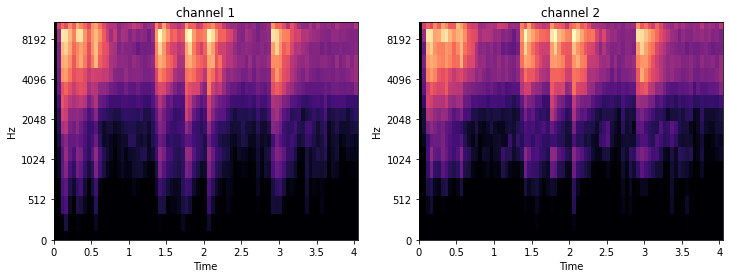

In [7]:
def vis_array(Sdb):
    fig, axes = plt.subplots(figsize=(12, 4), nrows = 1 , ncols = 2)
    ax1, ax2 = axes.flatten()

    img = specshow(np.rot90(Sdb[:, :, 0]), x_axis='time', y_axis='mel',
                ax=ax1, sr=SAMPLING_RATE, hop_length=HOP_LENGTH)

    ax1.set_title(f'channel 1')


    img = specshow(np.rot90(Sdb[:, :, 1]), x_axis='time', y_axis='mel',
                ax=ax2, sr=SAMPLING_RATE, hop_length=HOP_LENGTH)

    ax2.set_title(f'channel 2')

    plt.show()
    
vis_array(ap.S_db)

In [ ]:
# edit 